In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

/Users/boles/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Import Data

In [2]:
df = pd.read_csv("./data/carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


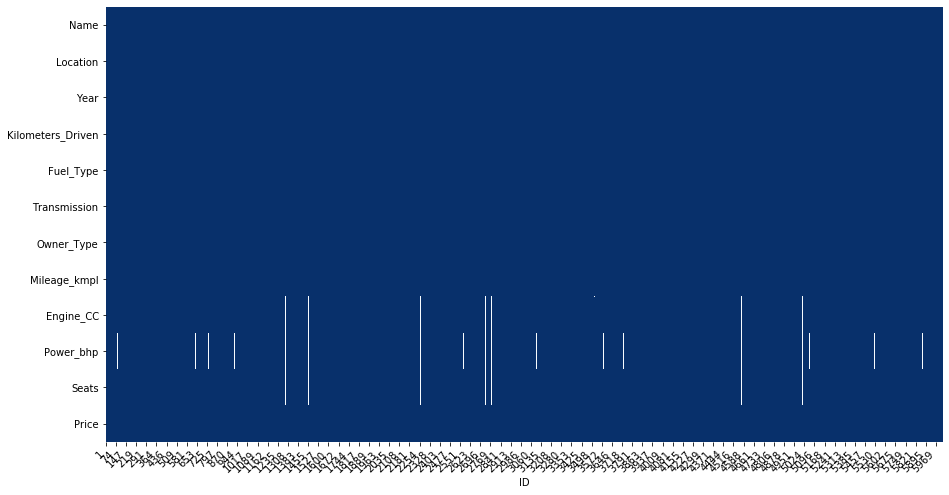

In [3]:
plot_missing_value(df)

In [4]:
 ??plot_missing_value

In [5]:
df.Name.value_counts()

Mahindra XUV500 W8 2WD                          49
Maruti Swift VDI                                45
Maruti Swift Dzire VDI                          34
Honda City 1.5 S MT                             34
Maruti Swift VDI BSIV                           31
                                                ..
Nissan Sunny 2011-2014 XL AT Special Edition     1
Hyundai i20 Era 1.4 CRDi                         1
Toyota Corolla Altis Aero D 4D J                 1
Mini Cooper Convertible 1.6                      1
Maruti Swift AMT DDiS VDI                        1
Name: Name, Length: 1849, dtype: int64

In [6]:
df.drop(columns=["Name"], inplace=True)

In [7]:
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 10), (1191, 10), (4762,), (1191,))

# Preprocessor

In [8]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats
ID,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0


In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

# Training

In [10]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

/Users/boles/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/boles/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [12]:
params = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7),
    'algo__kernel': ['linear', 'rbf']
}

In [13]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:   11.1s finished


{'algo__C': 10.0, 'algo__gamma': 0.001, 'algo__kernel': 'rbf'}
0.4191924234077009 0.08719422320538917 0.055845667362476537


/Users/boles/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


# Scaling can help SVM and KNN

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:   12.7s finished
/Users/boles/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1, 'algo__kernel': 'rbf'}
0.8692907569381978 0.8365068850275925 0.8314246832596819


# Polynomial Features

In [15]:
from luwiji.svm import demo

In [16]:
demo.poly_features()

interactive(children=(ToggleButtons(description='degree', options=(1, 2, 3), value=1), Checkbox(value=False, d…

In [18]:
gsp.svm_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=3, scaling="robust"), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:  1.5min finished
/Users/boles/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8692907569381978 0.8365068850275925 0.8314246832596819


# Save Model

In [34]:
save_model(model.best_estimator_, "car_price.pkl")

Model is pickled as model/car_price.pkl
